# Optimal charging station location on a cycleway


Consider a long linear cycle path  as Vento (VENezia-TOrino), or the Danube cycle path. The cycle path usually runs along the banks of a river with scarse tourist interest. However, from the main course of the cycle path it is possible to reach places of tourist interest by making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. These places, called **Points of Interest (POI)**  are not on the main trajectory of the cyclepath, but the bikers must deviate to reach them.

We assume that the bikers enter the cyclepath where it begins and finish the trip ath the end of the cyclepath. When they enter the battery is fully charged. Moreover, the bikers will make all possible deviations in order to visit all the POIs.







## Formulation

To support the formulation we make use of a graph with $2n+2$ nodes.
Nodes $s$ and $t$ represent the extremes of the cyclepath.

Nodes

*   $L = \{1,\ldots,n\}$:  locations along the cyclepath from which bikers deviate


*   $H = \{1',\ldots, n'\}$:  POIs that may host a charging station.

*   $\{s,t\}$: extremes of the cyclepath.

Arcs

*  $\{(i,i+1), (i+1, i) 1,\ldots,n \}$: arcs of the cyclepath in the two directions

*  $\{(i,i'), (i',i), i\in L, i'\in H\}$: arcs representing the deviations from the cyclepath

### Example of the graph
![picture](https://drive.google.com/file/d/1A4dSP-4K1E3jwaab4A8JT21TKD7FINaK/view?usp=drive_link)

### Parameters

*   $d_{i,i+1}, d_{i+1,i}, i=1,\ldots,n-1$: energy consumption between consecutive nodes,
*   $d_{i,i'}, d_{i',i}, i \in L, i'\in H$: energy consumption for the deviations
*   $c_i'$: cost of installing a charging station in site $i' \in H$
*   $\Delta$: maximum energy consumption between consecutive charging stations

We assume that $d_{s,1} d_{1,s} = d_{n,t} = d_{t,n} = 0$.
Note that the energy consumption on each arc can be different in the two directions, depending on the orography.








## Problem 1

Consider a biker that traverses the cyclepath from $s$ to $t$, determine in which nodes of $H$ to install the charging stations so that the maximum energy consumption between two consecutive charging stations is no more than $\Delta$ and minimize the overall cost.



## Problem 2

Consider a biker that traverses the cyclepath from $t$ to $s$, determine in which nodes of $H$ to install the charging stations so that the maximum energy consumption between two consecutive charging stations is no more than $\Delta$ and minimize the overall cost.

### Comments
Do you obtain the same solution? Why?

### Recommendation
The problems can be solved by a simple formulation. The solution of complex problems as the TSP is not necessary.
Do not use external libraries apart from those presented in class.



In [32]:
#import libraries

!pip install mip
!pip install --upgrade cffi==1.15.0
import importlib
import cffi
importlib.reload(cffi)
import numpy as np
import math
import networkx as nx

## Solution Problem 1

In [33]:
#data PROBLEM 1
n = 15  # number of nodes on the main course
n1 = 15 #number of touristic sites
delta = 50  # max distance before recharge
s = 0   # starting point
t = n  # destination
c = [20, 32, 11, 37, 7, 14, 22, 5, 35, 17, 23, 3, 26, 24] # consumption (in Wh) between two consecutive location along the main course
c_d = [1.1, 0.7, 0.4, 0.9, 2.1, 1.8, 0.5, 0.4, 1.6, 2.5, 1.4, 0.8, 2.0, 1.3, 0.1] # consumption (in Wh) of the deviation
inst_cost = [1492, 1789, 1914, 1861, 1348, 1769, 1123, 1432, 1564, 1818, 1901, 1265, 1642, 1712, 1756] #cost (in €) of installation of a charging point related to the node

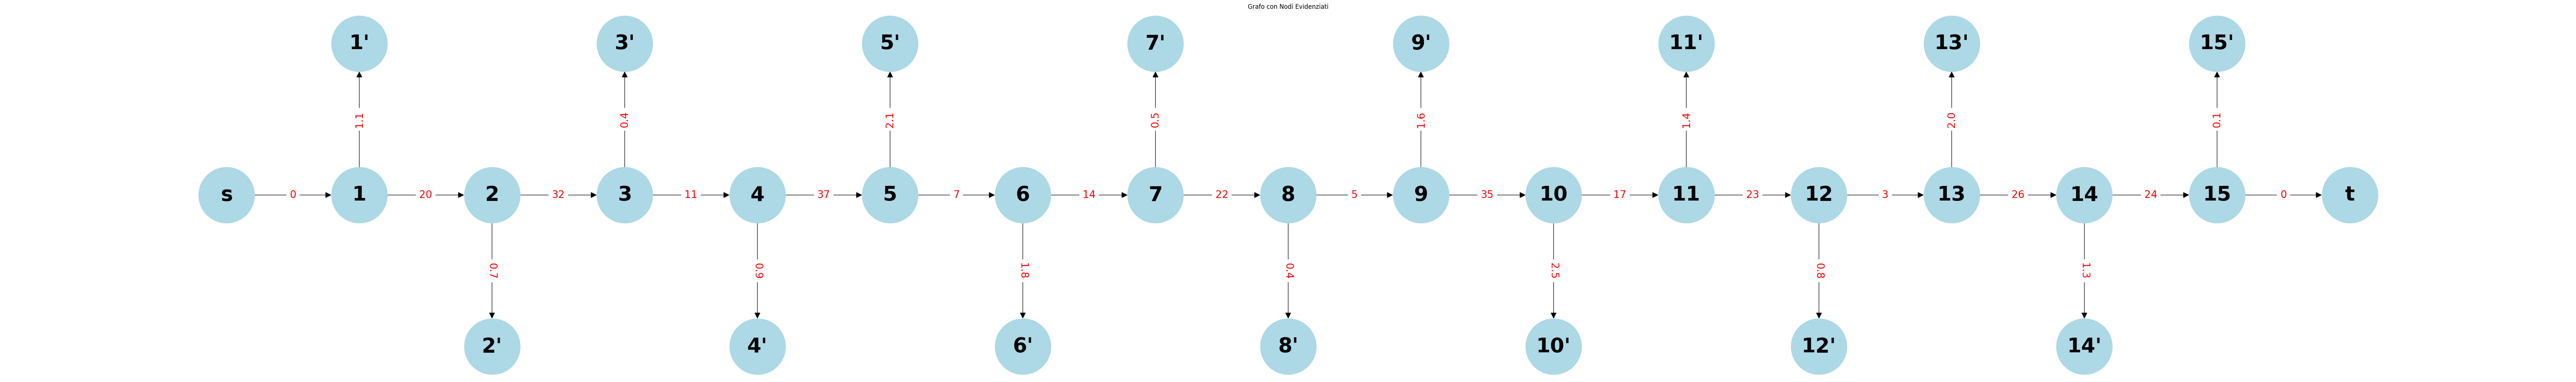

In [34]:
import networkx as nx
import matplotlib.pyplot as plt

# Creazione del grafo
G = nx.DiGraph()

# Aggiunta degli archi principali com i rispettivi pesi
main_edges = [ (i, i + 1, c[i - 1]) for i in range(1,15)]
G.add_weighted_edges_from(main_edges)

# Aggiunta degli archi secondari con i rispettivi pesi
secondary_edges = [(i, f'{i}\'', c_d[i - 1]) for i in range(1,16)]
G.add_weighted_edges_from(secondary_edges)

# Aggiunta dei nodi s e t
G.add_node('s')
G.add_node('t')

# Collegamento del nodo s al nodo 1
G.add_edge('s', 1, weight=0)

# Collegamento del nodo 15 al nodo t
G.add_edge(15, 't', weight=0)

# Creazione dizionario coordinate nodi
pos = {'s': (0, 0)}
for i in range(1, 16):
    pos[i] = (i, 0)
pos['t'] = (16, 0)

for i, node in enumerate(["1'", "2'", "3'", "4'", "5'", "6'", "7'", "8'", "9'", "10'", "11'", "12'", "13'", "14'", "15'"]):
    pos[node] = (i + 1, 1 if i % 2 == 0 else -1) # Posiziona i nodi con l'apostrofo alternati sopra e sotto la linea principale

# Disegno del grafo
plt.figure(figsize=(70, 10))
nx.draw(G, pos = pos, with_labels=True, node_size=12000, node_color='lightblue', font_size=40, font_weight='bold', arrowsize=25)

# Disegno dei pesi degli archi
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos = pos , edge_labels=edge_labels, font_color='red', font_size=20)

plt.title('Grafo con Nodi Evidenziati')
plt.show()

In [35]:
import mip
import numpy as np

# Create model
m = mip.Model()

# define the variable
x = [m.add_var(var_type=mip.BINARY) for i in range(n1)]  # charging stations
y = [m.add_var(var_type=mip.CONTINUOUS, lb=0) for i in range(n1)] # y[i] is zero if x[i] = 0, otherwise it's equal to the energy consumed until station i
#  define the contraints
M = 500
m.add_constr(  2*c_d[0] + c[0] + c_d[0] <= delta + M*x[0]  )
m.add_constr(  y[0] == (1-x[0])*c_d[0]  )
for i in range(1, n1-1):
    m.add_constr(  y[i-1] + c_d[i-1] + c[i-1] + 2*c_d[i] + c[i] + c_d[i+1] <= delta + M*x[i] )
    m.add_constr(  y[i] <= M*(1-x[i])  )
    m.add_constr(  y[i-1] + c_d[i-1] + c[i-1] + c_d[i] <= y[i] + M*x[i]  )
    m.add_constr(  y[i-1] + c_d[i-1] + c[i-1] + c_d[i] >= y[i] - M*x[i]  )
m.add_constr(  y[n1-2] + c_d[n1-2] + c[n1-2] + 2*c_d[n1-1] <= delta + M*x[n1-1]  )

# minimize cost of installation
m.objective = mip.minimize(np.dot(inst_cost, x))

# optimitation of the model
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [36]:
stazioni_instal = [(i+1) for i, _ in enumerate(x) if x[i].x != 0 ]
print("PROBLEMA 1 \nValore funzione obbiettivo: %d \nStazioni installate: %s" %(m.objective_value, stazioni_instal))

PROBLEMA 1 
Valore funzione obbiettivo: 12348 
Stazioni installate: [2, 4, 5, 7, 8, 10, 12, 14]


## Solution Problem 2

In [37]:
#data PROBLEM 2

n = 15  # number of nodes on the main course
n1 = 15 #number of touristic sites
delta = 50  # max distance before recharge
s = 0   # starting point
t = n  # destination
c2 = [12, 24, 7, 8, 35, 21, 19, 9, 31, 15, 21, 6, 23, 29] # consumption (in Wh) between two consecutive location along the main course
c_d2 = [1.7, 2.1, 1.1, 0.3, 0.4, 2.3, 0.2, 0.9, 2.1, 4.3, 5.2, 0.1, 2.8, 0.9, 0.1] # consumption (in Wh) of the deviation


#to compute the installation cost you have to bring the vector from the PROBLEM 1 and reverse it
inst_cost_rev = inst_cost[::-1]

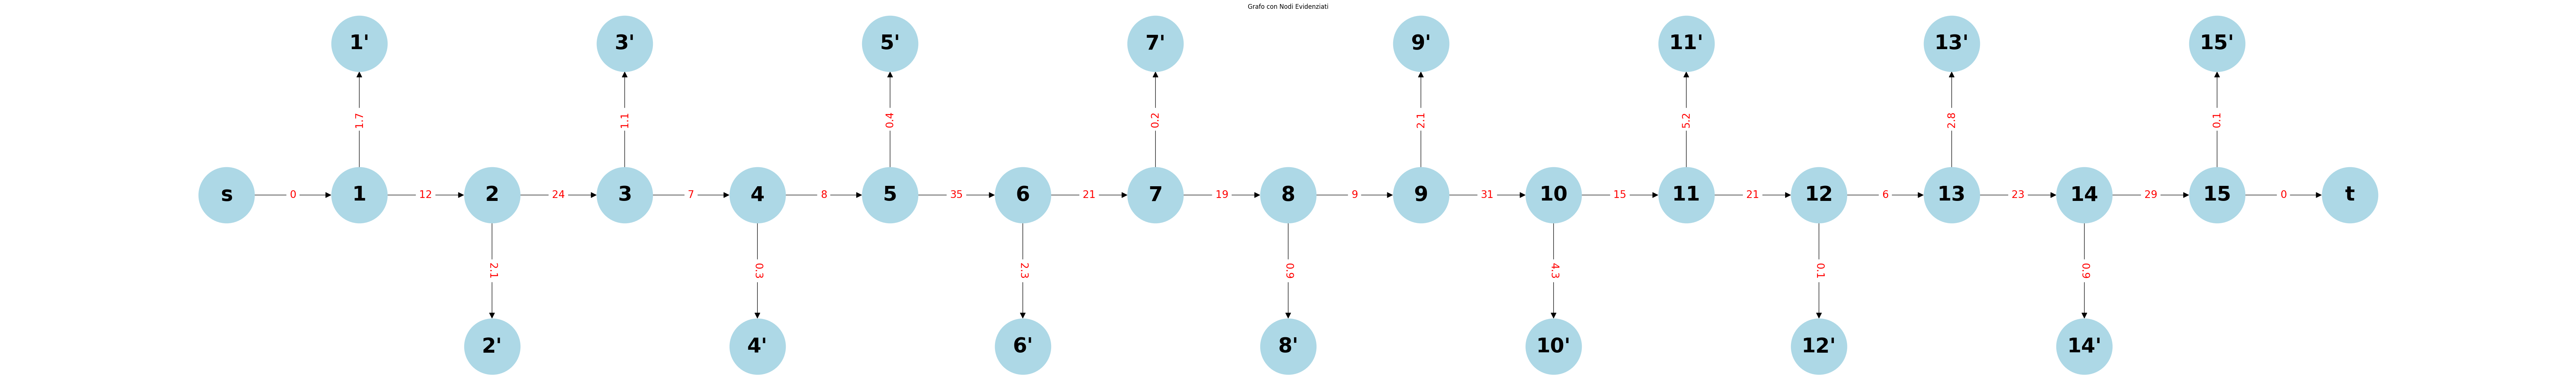

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

# Creazione del grafo
G = nx.DiGraph()

# Aggiunta degli archi principali com i rispettivi pesi
main_edges = [ (i, i + 1, c2[i - 1]) for i in range(1,15)]
G.add_weighted_edges_from(main_edges)

# Aggiunta degli archi secondari con i rispettivi pesi
secondary_edges = [(i, f'{i}\'', c_d2[i - 1]) for i in range(1,16)]
G.add_weighted_edges_from(secondary_edges)

# Aggiunta dei nodi s e t
G.add_node('s')
G.add_node('t')

# Collegamento del nodo s al nodo 1
G.add_edge('s', 1, weight=0)

# Collegamento del nodo 15 al nodo t
G.add_edge(15, 't', weight=0)

# Creazione dizionario coordinate nodi
pos = {'s': (0, 0)}
for i in range(1, 16):
    pos[i] = (i, 0)
pos['t'] = (16, 0)

for i, node in enumerate(["1'", "2'", "3'", "4'", "5'", "6'", "7'", "8'", "9'", "10'", "11'", "12'", "13'", "14'", "15'"]):
    pos[node] = (i + 1, 1 if i % 2 == 0 else -1) # Posiziona i nodi con l'apostrofo alternati sopra e sotto la linea principale

# Disegno del grafo
plt.figure(figsize=(70, 10))
nx.draw(G, pos = pos, with_labels=True, node_size=12000, node_color='lightblue', font_size=40, font_weight='bold', arrowsize=25)

# Disegno dei pesi degli archi
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos = pos , edge_labels=edge_labels, font_color='red', font_size=20)

plt.title('Grafo con Nodi Evidenziati')
plt.show()

In [39]:
import mip
import numpy as np

# Create model
m = mip.Model()

# define the variable
x = [m.add_var(var_type=mip.BINARY) for i in range(n1)]  # charging stations
y = [m.add_var(var_type=mip.CONTINUOUS, lb=0) for i in range(n1)] # y[i] is zero if x[i] = 0, otherwise it's equal to the energy consumed until station i
#  define the contraints
M = 500
m.add_constr(  2*c_d2[0] + c2[0] + c_d2[0] <= delta + M*x[0]  )
m.add_constr(  y[0] == (1-x[0])*c_d2[0]  )
for i in range(1, n1-1):
    m.add_constr(  y[i-1] + c_d2[i-1] + c2[i-1] + 2*c_d2[i] + c2[i] + c_d2[i+1] <= delta + M*x[i] )
    m.add_constr(  y[i] <= M*(1-x[i])  )
    m.add_constr(  y[i-1] + c_d2[i-1] + c2[i-1] + c_d2[i] <= y[i] + M*x[i]  )
    m.add_constr(  y[i-1] + c_d2[i-1] + c2[i-1] + c_d2[i] >= y[i] - M*x[i]  )
m.add_constr(  y[n1-2] + c_d2[n1-2] + c2[n1-2] + 2*c_d2[n1-1] <= delta + M*x[n1-1]  )

# minimize cost of installation
m.objective = mip.minimize(np.dot(inst_cost_rev, x))

# optimitation of the model
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [40]:
stazioni_instal = [(i+1) for i, _ in enumerate(x) if x[i].x != 0 ]
print("PROBLEMA 2 \nValore funzione obbiettivo: %d \nStazioni installate: %s" %(m.objective_value, stazioni_instal))

PROBLEMA 2 
Valore funzione obbiettivo: 12924 
Stazioni installate: [3, 4, 6, 8, 10, 11, 12, 14]


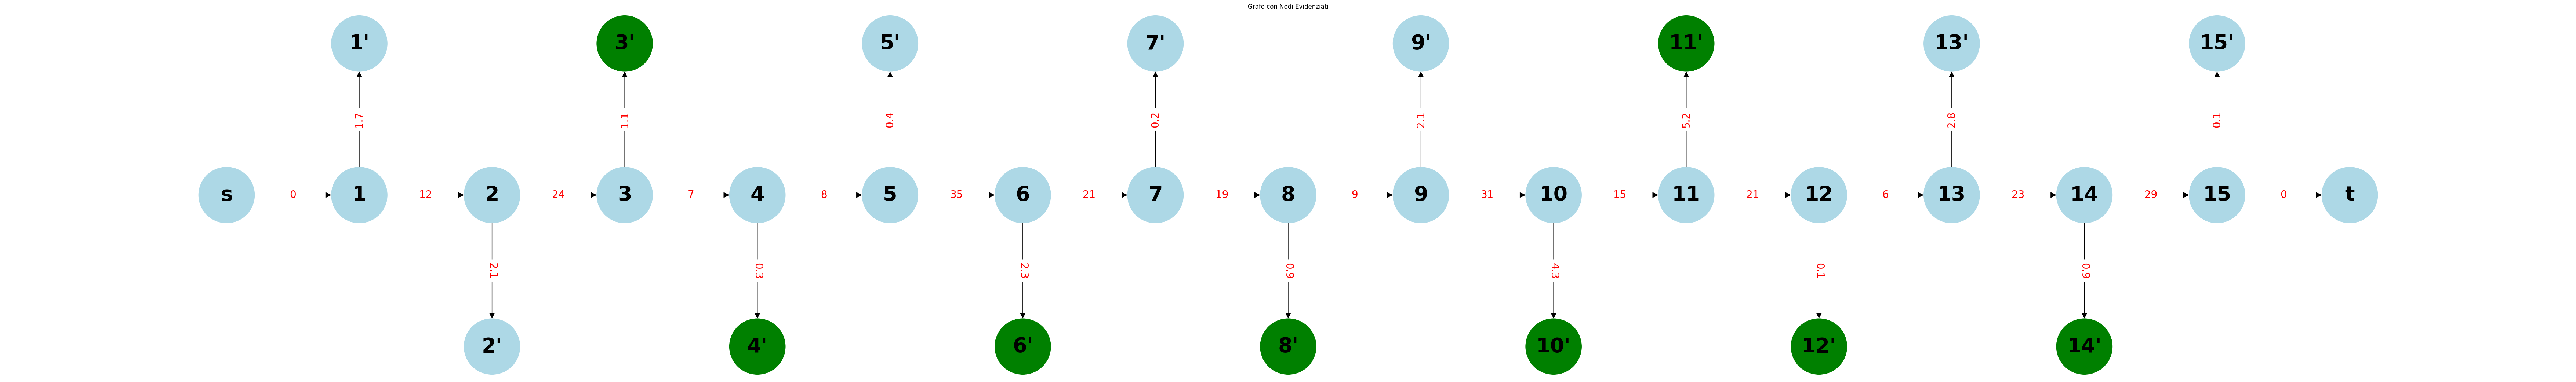

In [41]:
#print the path, visualize it with a figure

import networkx as nx
import matplotlib.pyplot as plt

# Creazione del grafo
G = nx.DiGraph()

# Aggiunta degli archi principali com i rispettivi pesi
main_edges = [ (i, i + 1, c2[i - 1]) for i in range(1,15)]
G.add_weighted_edges_from(main_edges)

# Aggiunta degli archi secondari con i rispettivi pesi
secondary_edges = [(i, f'{i}\'', c_d2[i - 1]) for i in range(1,16)]
G.add_weighted_edges_from(secondary_edges)

# Aggiunta dei nodi s e t
G.add_node('s')
G.add_node('t')

# Collegamento del nodo s al nodo 1
G.add_edge('s', 1, weight=0)

# Collegamento del nodo 15 al nodo t
G.add_edge(15, 't', weight=0)

# Creazione dizionario coordinate nodi
pos = {'s': (0, 0)}
for i in range(1, 16):
    pos[i] = (i, 0)
pos['t'] = (16, 0)

for i, node in enumerate(["1'", "2'", "3'", "4'", "5'", "6'", "7'", "8'", "9'", "10'", "11'", "12'", "13'", "14'", "15'"]):
    pos[node] = (i + 1, 1 if i % 2 == 0 else -1) # Posiziona i nodi con l'apostrofo alternati sopra e sotto la linea principale

# Creazione della lista di colori per i nodi
node_colors = []
for node in G.nodes():
    if node in ["3'", "4'", "6'", "8'", "10'", "11'", "12'", "14'"]:
        node_colors.append('green')  # Colore rosso per i nodi dove installo stazione
    else:
        node_colors.append('lightblue')  # Colore blu chiaro per gli altri nodi

# Disegno del grafo
plt.figure(figsize=(70, 10))
nx.draw(G, pos = pos, with_labels=True, node_size=12000, node_color=node_colors, font_size=40, font_weight='bold', arrowsize=25)

# Disegno dei pesi degli archi
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos = pos , edge_labels=edge_labels, font_color='red', font_size=20)

plt.title('Grafo con Nodi Evidenziati')
plt.show()



Do you obtain the same solution? Why?  
I due problemi sono caratterizzati da soluzioni ottime diverse (all'andata si installa un'insieme di stazioni diverso da quello trovato per il ritorno), in particolare per il percorso di ritorno i costi d'installazione ottimi sono maggiori.
Questa caratterizzazione deriva dal fatto che i due problemi sono formulati diversamente, in particolare hanno:
- funzione obiettivo identiche;<br>
- insiemi e tipi delle variabili identici;<br>
- stessi coefficienti moltiplicativi dei vincoli (condividono la stessa matrice A);<br>
- vettore dei termini noti differente;<br>

Il fatto che il vettore dei termini noti b2 differisca da b1, fa si che ogni vincolo nel problema uno venga traslato di una certa quantità nella direzione del gradiente. Ne consegue che la regione ammissibile di P2 risulterà deformata rispetto a quella di P1, andando così a includere nuove soluzioni ammissibili e/o ad eliminare delle vecchie. In P2 si è quindi scartata la soluzione ottima di P1 non essendo più ammissibile, e si è scelta una soluzione ottima peggiore della precedente, dal momento che la nuova regione ammissibile non è riuscita a includere nuove soluzioni, che siano migliori di quella ottima in P1.
Verosimilmente il cambiamento dei consumi tra le tappe, ovvero della matrice A, tra un problema e l'altro, è dovuto al fatto che tratti del percorso che all'andata erano in salita (discesa), ora devono essere percorsi in discesa (salita), determinando un cambiamento nei consumi energetici della batteria